# UNet model to segment landfills from satellite images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/MVA/RS/src

/content/drive/MyDrive/MVA/RS/src


In [3]:
!pip install rasterio

In [4]:
import cv2
import torch
import torch.nn as nn
# import monai

import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio

from torch.utils.data import Dataset
import torch.nn.functional as F


In [5]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, set = 'train'):
        """
        Args:
            root_dir (string): Directory with all the images and masks.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'masks')
        self.image_names = [f for f in os.listdir(self.images_dir)]
        # order
        self.image_names.sort()
        np.random.seed(0)
        np.random.shuffle(self.image_names)
        self.set = set
        # 60% train 20% val and 20% test
        if set == 'train':
            self.image_names = self.image_names[:int(len(self.image_names)*0.6)]
        elif set == 'val':
            self.image_names = self.image_names[int(len(self.image_names)*0.6):int(len(self.image_names)*0.8)]
        elif set == 'test':
            self.image_names = self.image_names[int(len(self.image_names)*0.8):]
        else:
            raise ValueError('set must be "train", "val" or "test"')

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_names[idx])
        mask_name = os.path.join(self.masks_dir, f'mask_{self.image_names[idx].split("_")[1]}')  # Adjust based on your naming convention
        image = plt.imread(img_name)
        mask = plt.imread(mask_name)

        # # resize both image and mask to 256x256
        image = cv2.resize(image, (256, 256))[:, :, :3]
        mask = cv2.resize(mask, (256, 256))

        # mask of size 256x256
        mask = mask[:, :, 0]
        mask[mask > 0] = 1
        # Convert mask to binary
        sample = {'image': image, 'mask': mask}

        return image, mask

In [17]:
# create datalaoder. SPlit images from the dataset into train, validation and test with a split I can reproduce
path_to_data = '../data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
bs = 16

train_dataset = ImageDataset(path_to_data, set = 'train')
val_dataset = ImageDataset(path_to_data, set = 'val')
test_dataset = ImageDataset(path_to_data, set = 'test')

cuda


In [7]:
train_dataset.image_names = train_dataset.image_names[:1]
val_dataset.image_names = val_dataset.image_names[:1]
test_dataset.image_names = test_dataset.image_names[:1]

In [23]:
# get length of datasets
print(f'Length of train dataset: {len(train_dataset)}')
print(f'Length of val dataset: {len(val_dataset)}')
print(f'Length of test dataset: {len(test_dataset)}')


Length of train dataset: 591
Length of val dataset: 197
Length of test dataset: 198


In [24]:
# load data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True)


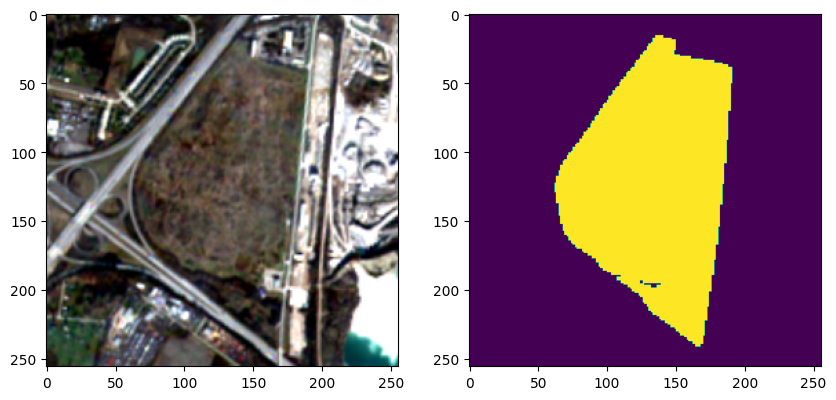

In [10]:
# plot the first image and mask from train_loader
image, mask = next(iter(train_loader))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image[0])
ax[1].imshow(mask[0])
plt.show()

In [11]:
print(image.shape)
print(image.dtype)
print(mask.shape)
print(mask.dtype)
print(np.unique(mask[0, :, :]))
print(image[0, :, :].min())
print(image[0, :, :].max())

torch.Size([1, 256, 256, 3])
torch.float32
torch.Size([1, 256, 256])
torch.float32
[0. 1.]
tensor(0.)
tensor(1.)


Input image have 3 channels and 256*256 pixels. There have values between 0 and 1, with type float32.
Masks take values 0 or 1, type float32 too.

In [12]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [14]:
def IoU(pred, target):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / union

def IoU_rim(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) of two binary masks.

    Parameters:
        mask1 (np.array): First binary mask.
        mask2 (np.array): Second binary mask.

    Returns:
        float: IoU score.
    """
    # Intersection and Union calculations
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score


In [15]:
def train(model, criterion, optimizer, train_loader):
    #zero grad

    model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.permute(0, 3, 1, 2)
        # Forward pass
        outputs = model(images)
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        print('Step [{}/{}], Loss: {:.4f}'.format(i+1, len(train_loader), loss.item()))
    train_loss /= len(train_loader)
    return model, train_loss

def valid(model, criterion, val_loader):
    model.eval()
    valid_loss = 0
    iou_score = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device).float(), labels.to(device).float()
            images = images.permute(0, 3, 1, 2)
            outputs = model(images)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            binary_outputs = (outputs > 0.5).float().cpu()  # Move to CPU before numpy conversion
            labels = labels.cpu()
            iou_score += IoU_rim(binary_outputs.cpu().numpy(), labels.cpu().numpy())

        valid_loss /= len(val_loader)
        iou_score /= len(val_loader)
        return valid_loss, iou_score

In [35]:
nb_epochs = 30
learning_rate = 10e-5
model = UNet(3, 1).to(device)
criterion =  nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_IoUs = []
val_losses = []
for epoch in range(nb_epochs):
    model.train()
    model, train_loss = train(model, criterion, optimizer, train_loader)
    train_losses.append(train_loss)
    val_loss, val_iou = valid(model, criterion, val_loader)
    val_losses.append(val_loss)
    val_IoUs.append(val_iou)
    print(f'Epoch {epoch+1}/{nb_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val IoU: {val_iou}')

Step [1/37], Loss: 0.7100
Step [2/37], Loss: 0.6829
Step [3/37], Loss: 0.6745
Step [4/37], Loss: 0.6545
Step [5/37], Loss: 0.6693
Step [6/37], Loss: 0.6504
Step [7/37], Loss: 0.6567
Step [8/37], Loss: 0.6169
Step [9/37], Loss: 0.6555
Step [10/37], Loss: 0.6061
Step [11/37], Loss: 0.6435
Step [12/37], Loss: 0.5955
Step [13/37], Loss: 0.5934
Step [14/37], Loss: 0.6022
Step [15/37], Loss: 0.5673
Step [16/37], Loss: 0.5295
Step [17/37], Loss: 0.5584
Step [18/37], Loss: 0.5704
Step [19/37], Loss: 0.5711
Step [20/37], Loss: 0.5712
Step [21/37], Loss: 0.5672
Step [22/37], Loss: 0.5421
Step [23/37], Loss: 0.5492
Step [24/37], Loss: 0.5363
Step [25/37], Loss: 0.5191
Step [26/37], Loss: 0.5634
Step [27/37], Loss: 0.5370
Step [28/37], Loss: 0.5069
Step [29/37], Loss: 0.5477
Step [30/37], Loss: 0.5019
Step [31/37], Loss: 0.5240
Step [32/37], Loss: 0.5177
Step [33/37], Loss: 0.5006
Step [34/37], Loss: 0.4581
Step [35/37], Loss: 0.4595
Step [36/37], Loss: 0.5135
Step [37/37], Loss: 0.4666
Epoch 1/30

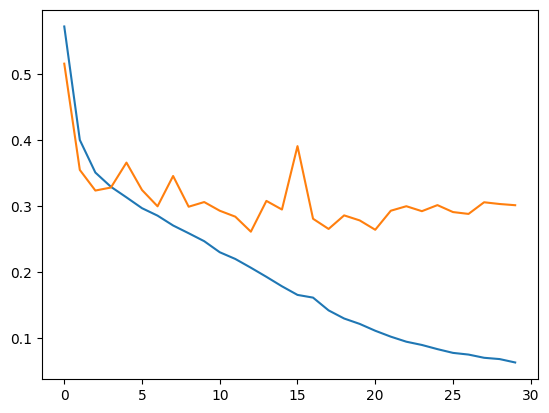

In [36]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.show()

In [38]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '../models/unet_model_30epochs.pth')

In [26]:
val_loss, val_iou = valid(model, criterion, val_loader)
print('Validation Loss: ', val_loss)
print('Validation IoU: ', val_iou)

In [28]:
print('Validation Loss: ', val_loss)
print('Validation IoU: ', val_iou)

Validation Loss:  0.3003834050435286
Validation IoU:  0.5288375726376252


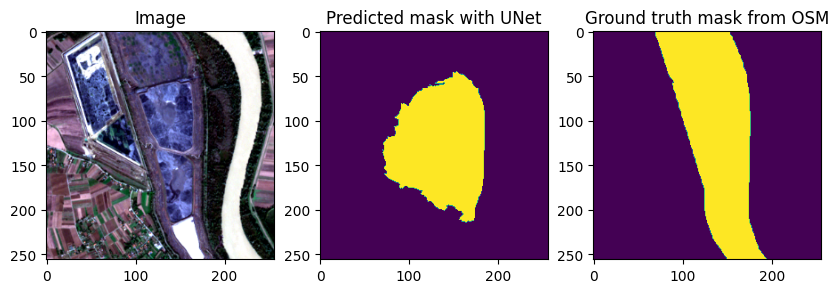

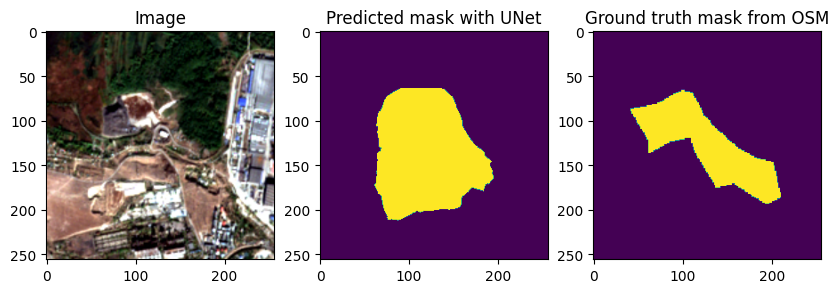

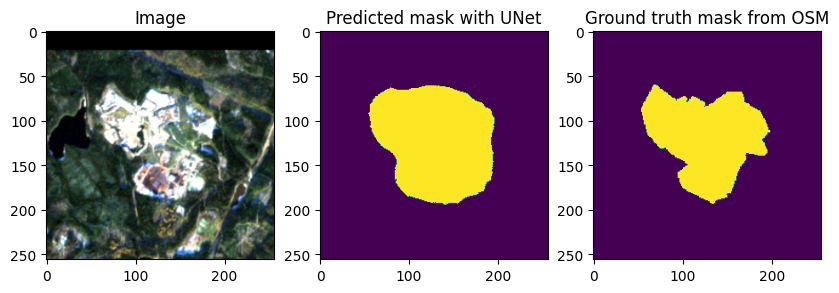

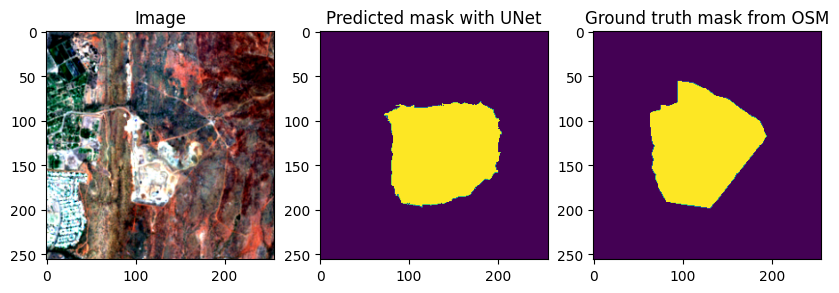

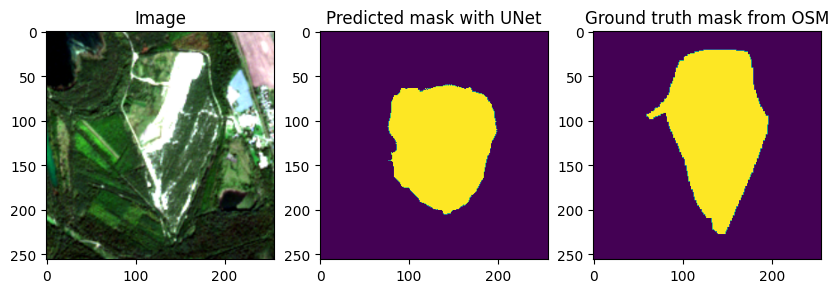

In [34]:
for i in range(5):
    image, mask = next(iter(train_loader))
    image = image.to(device)
    image = image.permute(0, 3, 1, 2)
    output = model(image)
    output = output.squeeze(1)
    output = (output > 0.0000001).float()
    output = output.cpu().numpy()
    mask = mask.numpy()
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image[0].cpu().permute(1, 2, 0))
    ax[1].imshow(output[0])
    ax[2].imshow(mask[0])
    ax[0].set_title('Image from Sentinel2')
    ax[1].set_title('Predicted mask with UNet')
    ax[2].set_title('Ground truth mask from OSM')
    plt.show()

In [39]:
test_loss, test_iou = valid(model, criterion, test_loader)
print('Test Loss: ', test_loss)
print('Test IoU: ', test_iou)

Test Loss:  0.291267712528889
Test IoU:  0.5969932609558241


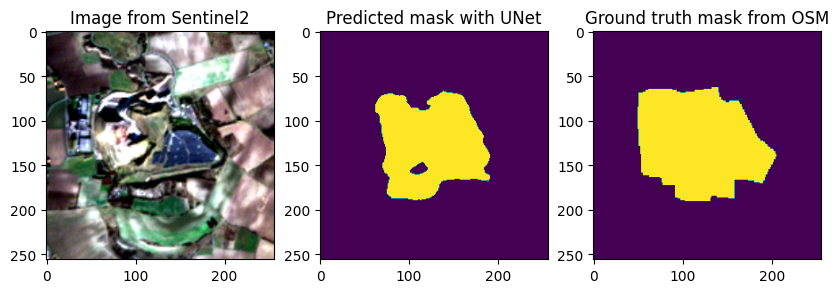

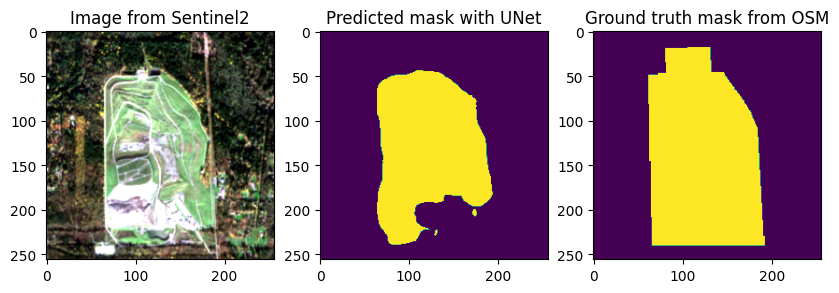

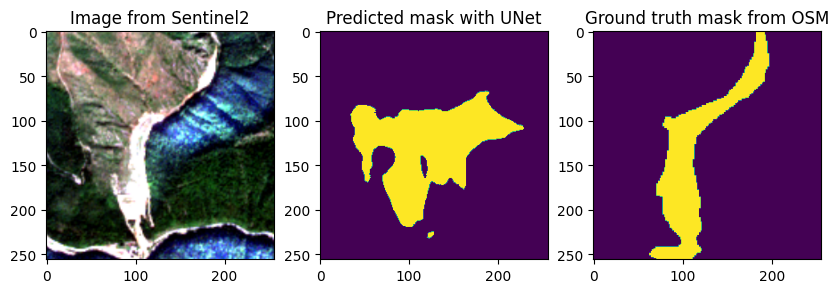

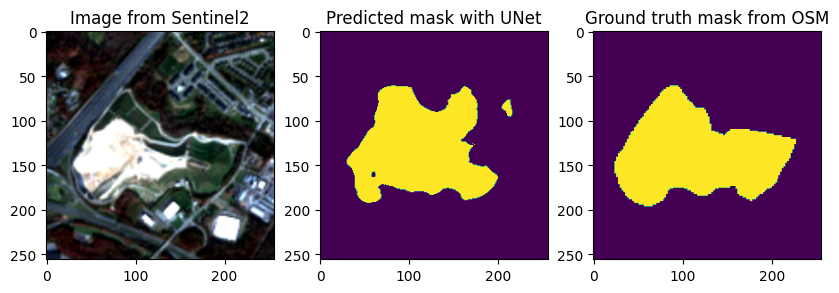

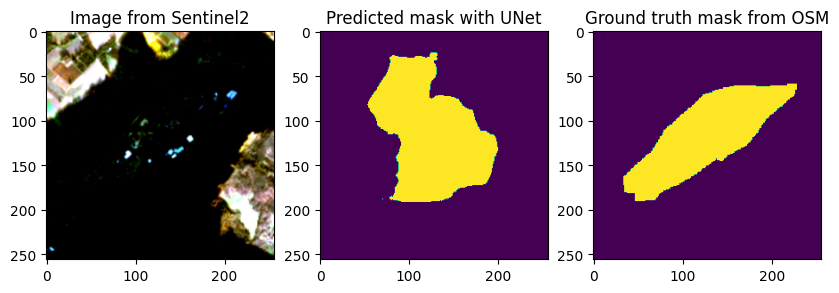

In [40]:
for i in range(5):
    image, mask = next(iter(test_loader))
    image = image.to(device)
    image = image.permute(0, 3, 1, 2)
    output = model(image)
    output = output.squeeze(1)
    output = (output > 0.0000001).float()
    output = output.cpu().numpy()
    mask = mask.numpy()
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image[0].cpu().permute(1, 2, 0))
    ax[1].imshow(output[0])
    ax[2].imshow(mask[0])
    ax[0].set_title('Image from Sentinel2')
    ax[1].set_title('Predicted mask with UNet')
    ax[2].set_title('Ground truth mask from OSM')
    plt.show()